1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

4. Shrinkage Method를 다르게

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from optimize_multi.backtest import simulate_strategy

from ryu_tool.mytool import draw_return_result, print_statistics, run_alpha_regression

2023-05-27 00:35:21,436	INFO worker.py:1625 -- Started a local Ray instance.


In [3]:
# S&P500 마켓 데이터 (결과 비교를 위해)
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

# Investing.com에서 받아와서 그런지 Timestamp에 문제가 있다
problem = [pd.Timestamp('2021-07-03 00:00:00'),
           pd.Timestamp('2021-07-04 00:00:00'),
           pd.Timestamp('2021-07-05 00:00:00'),
           pd.Timestamp('2021-08-07 00:00:00'),
           pd.Timestamp('2021-08-08 00:00:00')]

spx = spx.drop(problem)

In [4]:
# 필요한 데이터 불러오기
price = pd.read_pickle("Data/allstock_adj.pickle")
rtn = price.pct_change(fill_method=None)

spx_mask = pd.read_pickle("Data/spx_mask.pickle")

In [5]:
# Ray를 사용하기 위해 Ray데이터 생성
rtn_ray = ray.put(rtn)
mask_ray = ray.put(spx_mask)

In [6]:
look_back_list = [90, 120, 150, 180, 210, 240, 270, 330, 365]
#look_back_list2 = [90, 110, 130, 150, 170]
args_lst = [0.1, 1, 3, 5, 10, 20]
max_ratio_list = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

In [7]:
what = look_back_list

In [8]:
futures = [run_optimizer.remote(obj_function=obj_variance, 
                                rtn_df=rtn_ray,
                                spx_mask=mask_ray,
                                start_year="2007",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=arg,
                                max_ratio=1,
                                min_ratio=0,
                                shrinkage_method="None",
                                arg=arg)  for arg in what]
result = ray.get(futures)

 98%|█████████▊| 63/64 [26:35<00:12, 12.05s/it]


In [9]:
result_dict = {}
weight_dict = {}

for i, arg in enumerate(what):
    rt, weig = simulate_strategy(result[i], rtn, fee_rate=0.0015)
    result_dict[f"{arg}"] = rt # Look Back {arg} days
    weight_dict[str(arg)] = weig

100%|██████████| 64/64 [26:46<00:00, 25.10s/it]


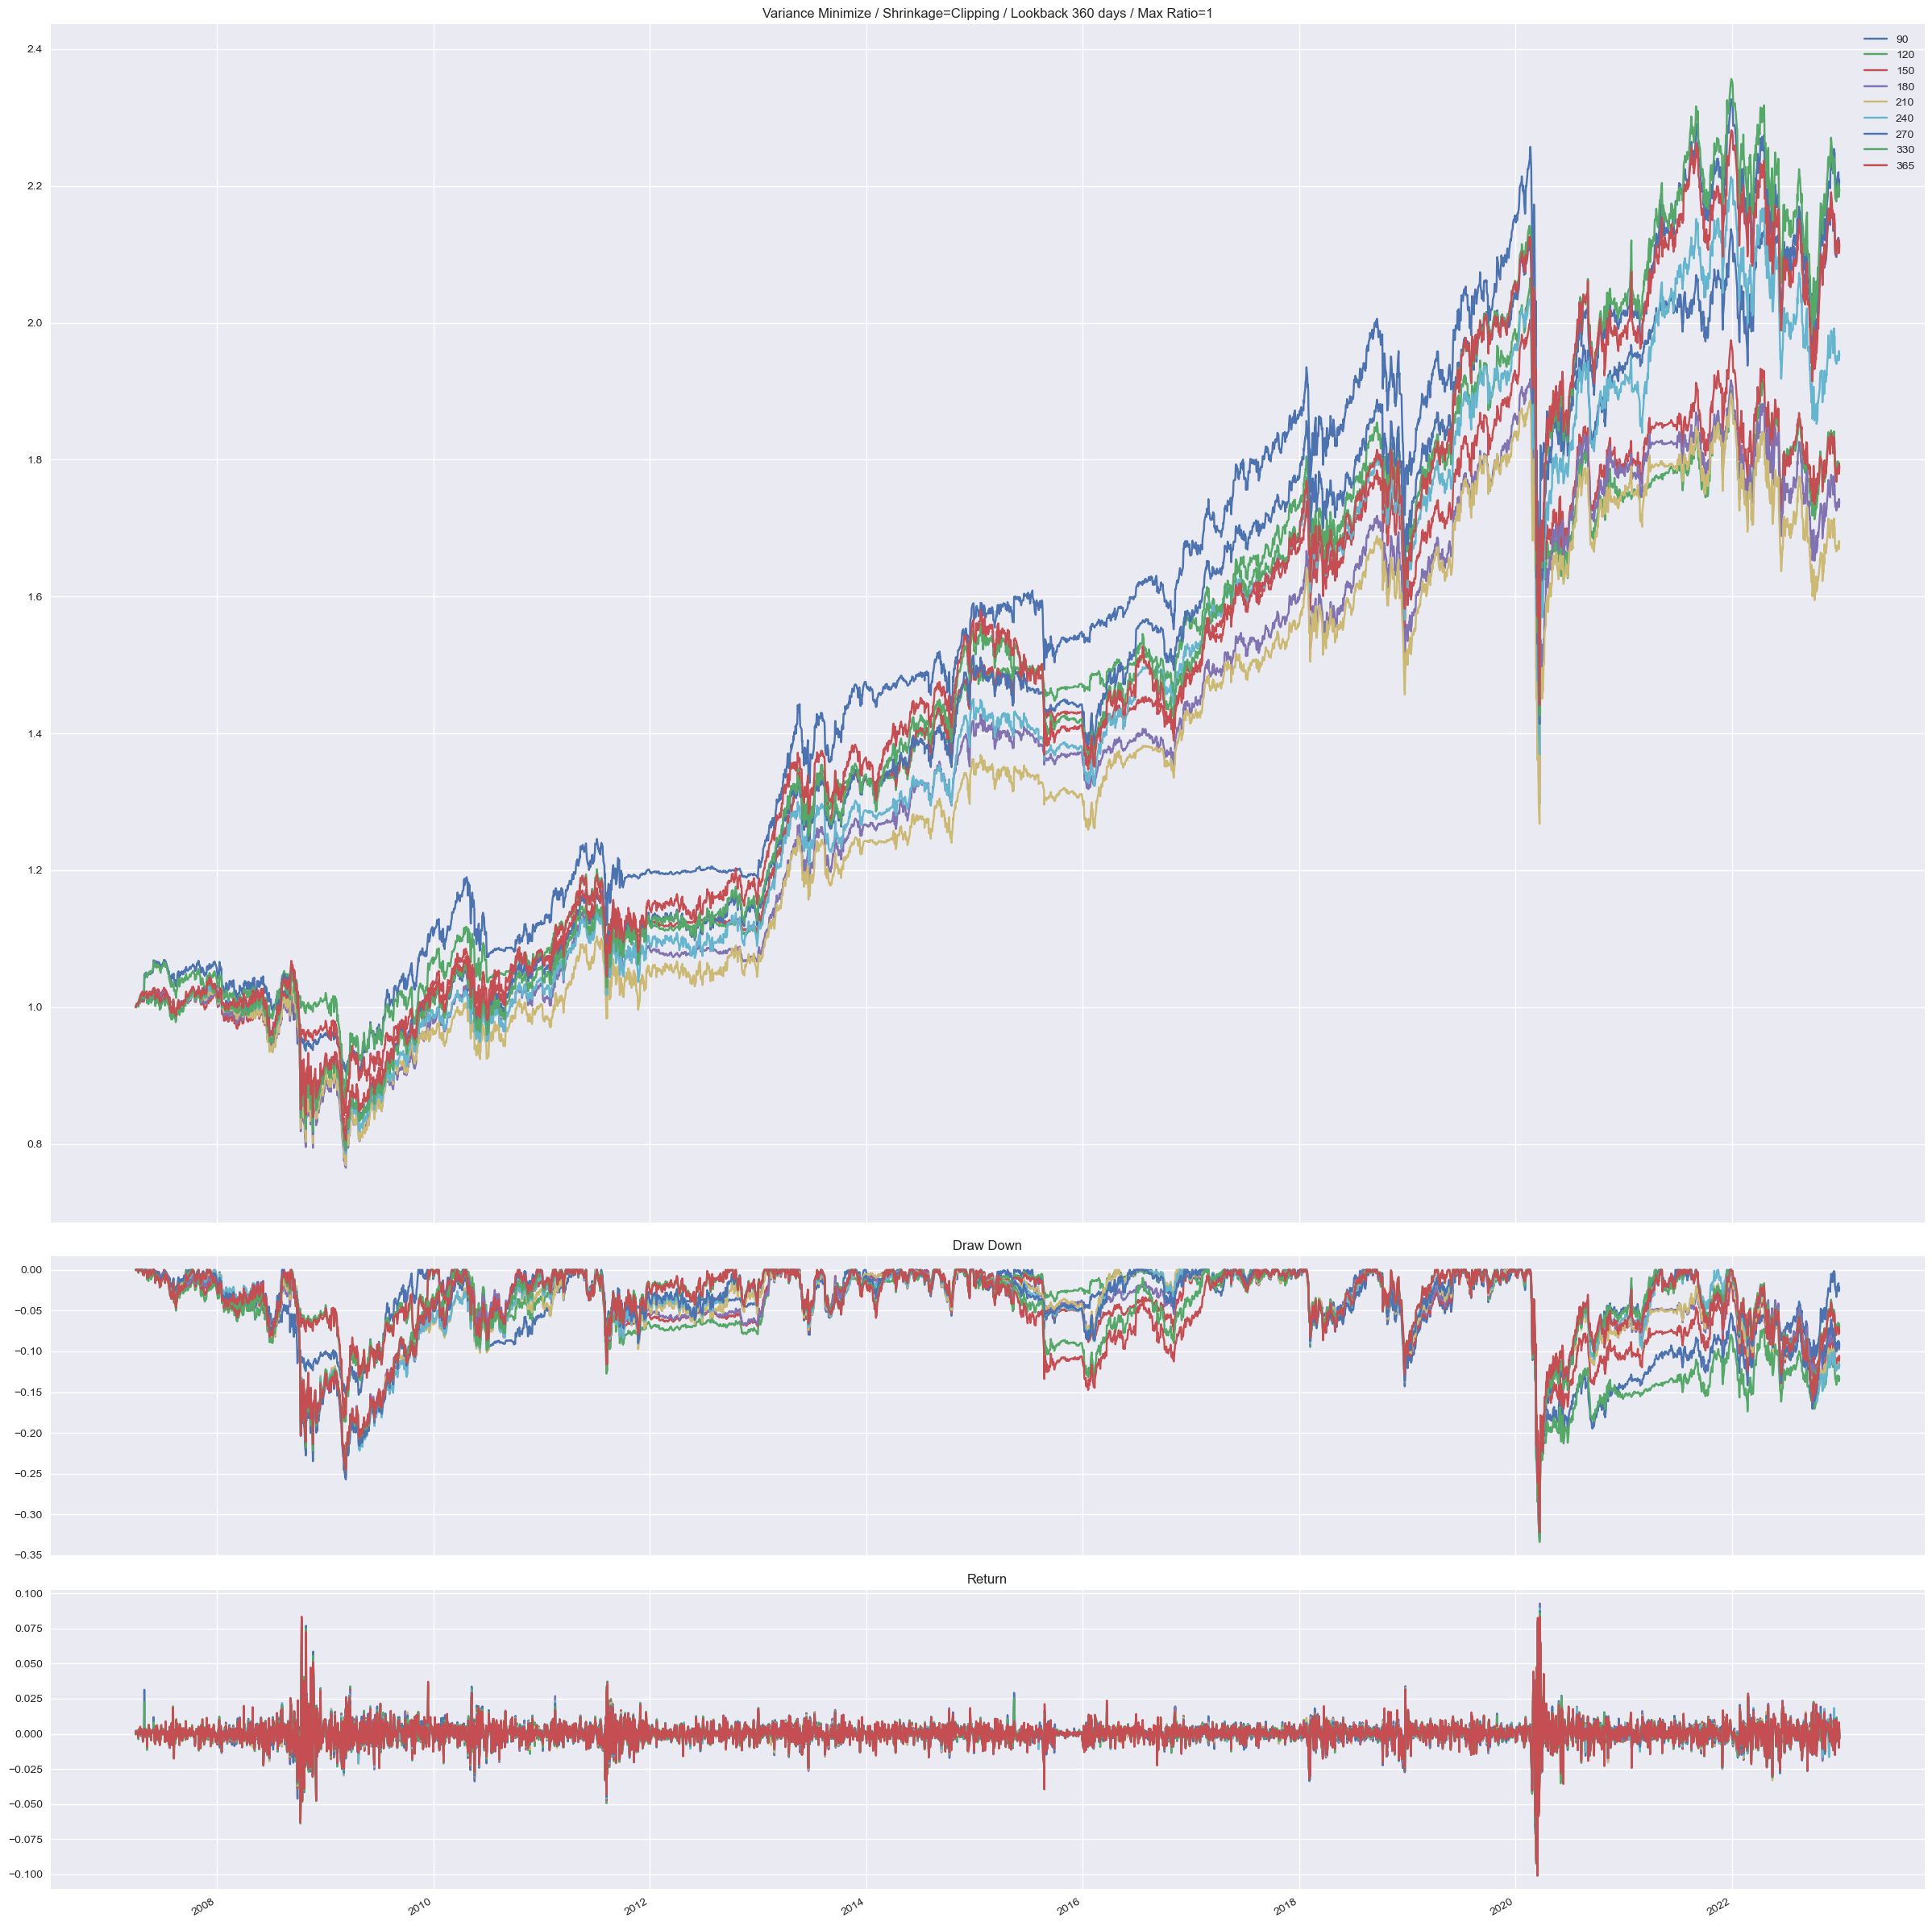

In [11]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Variance Minimize / Shrinkage=Clipping / Lookback 360 days / Max Ratio=1")

In [15]:
stats = print_statistics(result_dict)
stats.columns = [f"{day}" for day in what]
stats

,0.1,1,3,5,10,20
CAGR,0.046300,0.045500,0.053300,0.053400,0.051800,0.046100
Mean,0.079150,0.077990,0.088410,0.088340,0.086580,0.079400
STD,0.160039,0.159620,0.157775,0.157055,0.159095,0.163316
MDD,0.336000,0.336000,0.331000,0.330000,0.326000,0.334000
Sharpe,0.494568,0.488598,0.560355,0.562479,0.544202,0.486175


In [ ]:
weight_dict.keys()

Text(0.5, 1.0, 'Look Back Window = 150 days / shrinkage= None')

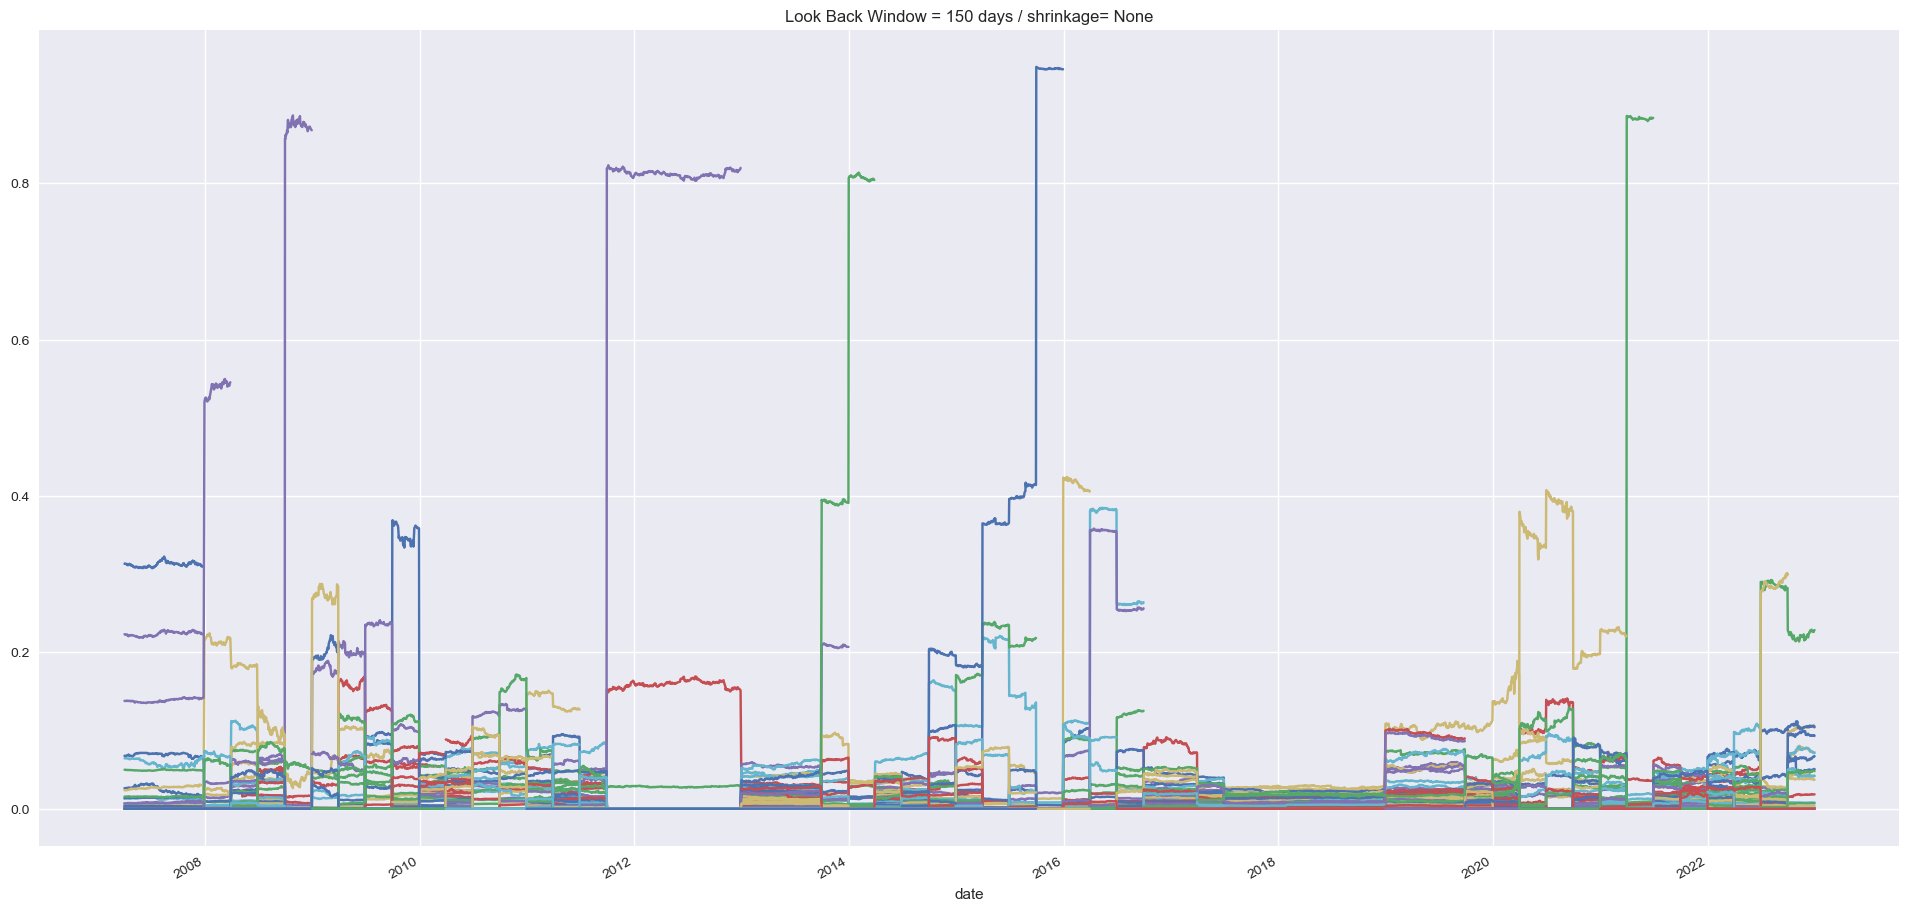

In [12]:
weight_dict["150"].plot(figsize=(24,12),
                        legend=False)
plt.title("Look Back Window = 150 days / shrinkage= None")

In [ ]:
result_dict.keys()

In [ ]:
portfolio = result_dict["Look Back 330 days"]
spx_sample = spx.loc[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Look Back 330 days 1.5X":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [ ]:
st = print_statistics({"a":portfolio,
                       "S&P500": spx_sample})
st.columns = ["330 1.5X","S&P500"]
st

In [ ]:
portfolio

In [ ]:
spx_sample

In [ ]:
run_alpha_regression({"Eigenvalue Clipping":portfolio},
                     mkt_rtn=spx_sample)